<a href="https://colab.research.google.com/github/Josphat-Malombe/deep_learning/blob/main/model_008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
#getting the data
import requests
import zipfile
from pathlib import Path

data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"
if image_path.is_dir():
  print("directory exists")
else:
  print("creating directory")
  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/ "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("downloading")
    f.write(request.content)

  with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping file")
    zip_ref.extractall(image_path)

creating directory
downloading
unzipping file


In [3]:
#inspecting the data
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f" there are {len(dirnames)} directories and {len(filenames)} images")

walk_through_dir(image_path)

 there are 2 directories and 0 images
 there are 3 directories and 0 images
 there are 0 directories and 46 images
 there are 0 directories and 46 images
 there are 0 directories and 58 images
 there are 3 directories and 0 images
 there are 0 directories and 154 images
 there are 0 directories and 150 images
 there are 0 directories and 146 images


In [4]:
#creating training and testing pahs
train_dir = image_path/ "train"
test_dir = image_path/ "test"

test_dir, train_dir

(PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi/train'))

Image class: sushi
Image Height: 512
image width: 512


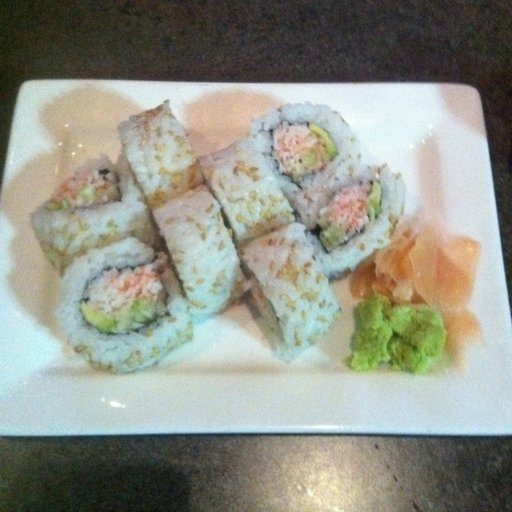

In [5]:
#visualizing image
import random
from PIL import Image
image_path_list=list(image_path.glob("*/*/*.jpg"))
random_image_path=random.choice(image_path_list)
image_class=random_image_path.parent.stem
img=Image.open(random_image_path)

print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

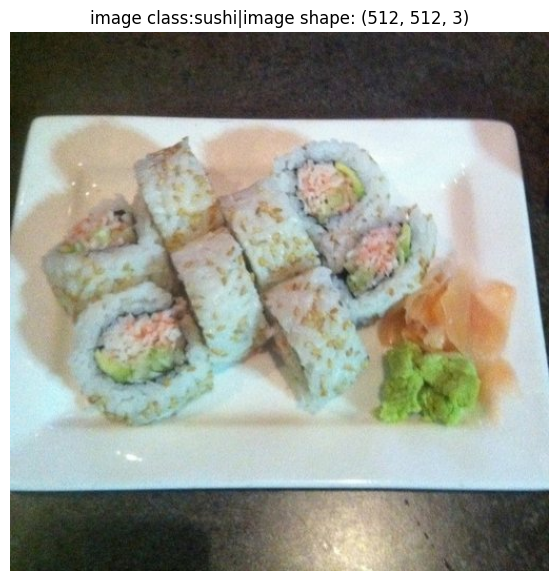

In [6]:
#visualizing using matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"image class:{image_class}|image shape: {img_as_array.shape}")
plt.axis(False)

In [7]:
#transforming data
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

data_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])

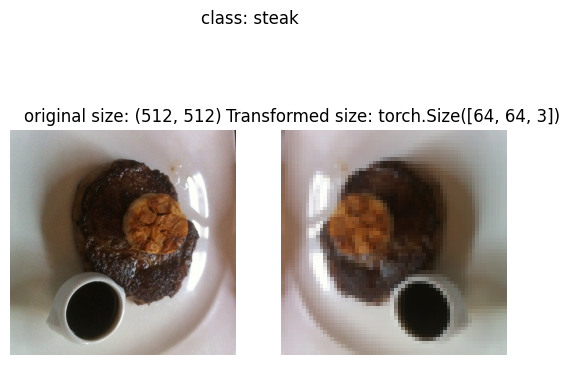

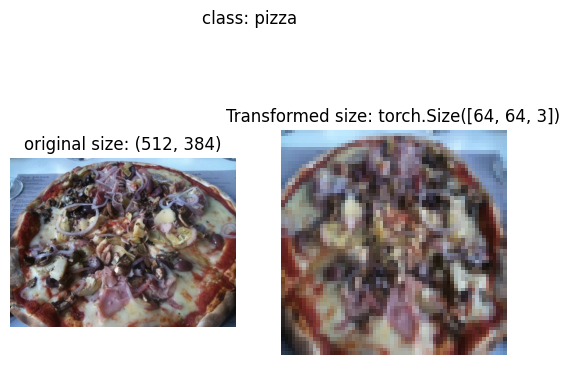

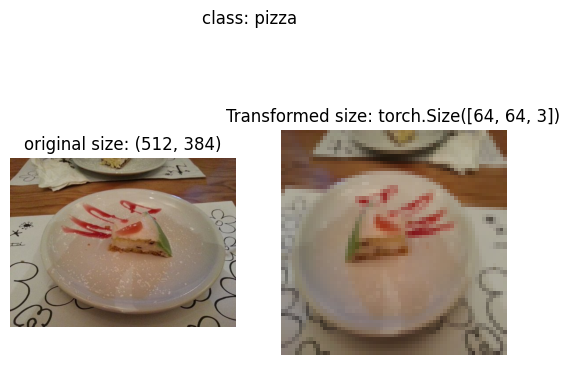

In [8]:
def plot_transformed_images(image_paths,transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"original size: {f.size}")
      ax[0].axis("off")

      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"class: {image_path.parent.stem}")

plot_transformed_images(image_path_list,transform=data_transform,n=3)

In [9]:
#useinng imagefolder to create dataset

train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir, transform=data_transform)

In [10]:
class_names=train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [11]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [12]:
len(train_data),len(test_data)

(450, 150)

In [13]:
#makiing the data iterable
train_dataloader=DataLoader(dataset=train_data,batch_size=1,num_workers=1,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=1,num_workers=1,shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c1b59a57010>,
 <torch.utils.data.dataloader.DataLoader at 0x7c1b599ed090>)

In [14]:
#loading image data with custom dataset
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List



In [15]:
target_dir=train_dir
print(f":::{target_dir}")
class_names_found=sorted([entry.name for entry in list(os.scandir(image_path/ "train"))])
print(f"{class_names_found}")

:::data/pizza_steak_sushi/train
['pizza', 'steak', 'sushi']


In [16]:
def find_classes(directory:str)->Tuple[List[str], Dict[str,int]]:
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}")

  class_to_idx={cls_name: i for i, cls_name in enumerate(classes)}
  return classes,class_to_idx


In [17]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [18]:
class ImageFolderCustom(Dataset):
  def __init__(self,targ_dir:str,transform=None)->None:
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform=transform
    self.classes,self.class_to_idx=find_classes(target_dir)
  def load_image(self,index:int)->Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self)->int:
    return len(self.paths)

  def __getitem__(self, index:int) -> Tuple[torch.tensor, int]:
    img=self.load_image(index)
    class_name=self.paths[index].parent.name
    class_idx=self.class_to_idx[class_name]
    if self.transform:
      return self.transform(img),class_idx
    else:
      return img , class_idx

In [19]:
train_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])
test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

In [20]:
train_data_custom=ImageFolderCustom(targ_dir=train_dir, transform=train_transform)
test_data_custom=ImageFolderCustom(targ_dir=test_dir, transform=test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c1b59a6fc10>,
 <__main__.ImageFolderCustom at 0x7c1b73006010>)

In [21]:
len(train_data_custom), len(test_data_custom)

(450, 150)

In [22]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [23]:
def display_random_images(dataset:torch.utils.data.dataset.Dataset,
                          classes: List[str]=None,
                          n: int = 10,
                          display_shape:bool=True,
                          seed:int=None):
  if n>10:
    n=10
    display_shape=False
  if seed:
    random.seed(seed)

  random_samples_idx=random.sample(range(len(dataset)),k=n)
  plt.figure(figsize=(16,8))
  for i,targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label = dataset[targ_sample][0],dataset[targ_sample][1]
    targ_image_adjust=targ_image.permute(1,2,0)
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title=f"class: {classes[targ_label]}"
      if display_shape:
        title=title+f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

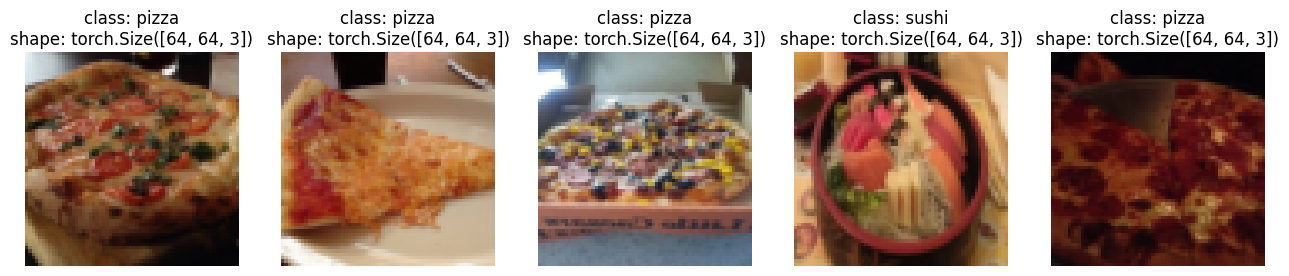

In [24]:
display_random_images(train_data,n=5,classes=class_names,seed=None)

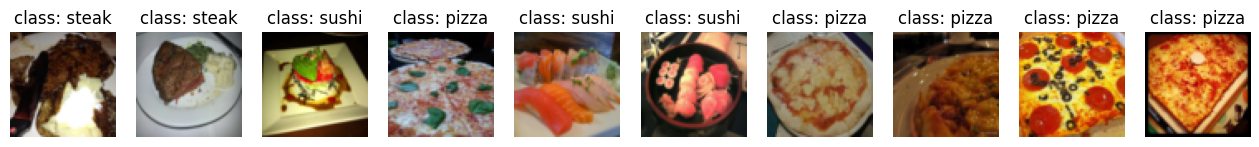

In [25]:
display_random_images(train_data_custom,n=12, classes=class_names,seed=None)

In [26]:
train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=1,num_workers=0,shuffle=True)
test_dataloader_custom=DataLoader(dataset=test_data_custom, batch_size=1,num_workers=0,shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c1b5984e6d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c1b59c60e90>)

In [27]:
#data augmentation
train_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])
test_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

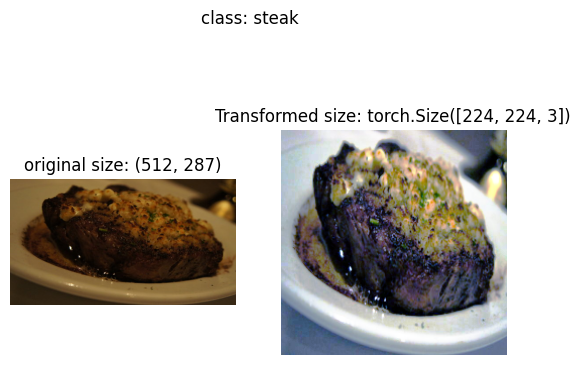

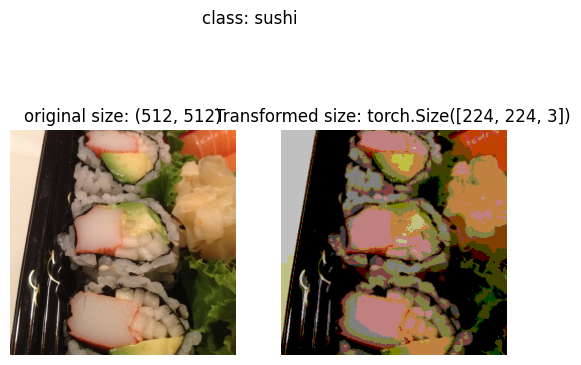

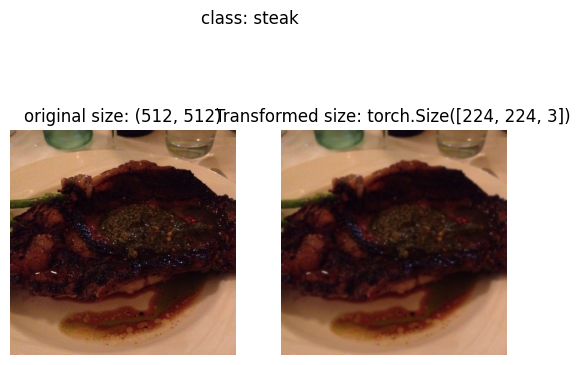

In [28]:
image_path_list=list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=3, seed=None)

In [29]:
#creating a computer vision model to predict the two foods

#transforms
simple_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
simple_test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [30]:
os.cpu_count()

2

In [31]:
#dataset and dataloader
train_data_simple=datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir, transform=simple_test_transform)

train_dataloader_simple=DataLoader(dataset=train_data_simple,batch_size=32, shuffle=True, num_workers=2)
test_dataloader_simple=DataLoader(dataset=test_data_simple, batch_size=32, shuffle=False, num_workers=os.cpu_count())

In [32]:
#tiny vgg model
class tinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int) ->None:
    super().__init__()
    self.conv_block1=nn.Sequential(
        nn.Conv2d(input_shape,hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv_block2=nn.Sequential(
        nn.Conv2d(hidden_units,hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,out_features=output_shape)
    )
  def forward(self,x:torch.Tensor):
    x=self.conv_block1(x)
    x=self.conv_block2(x)
    x=self.classifier(x)

    return x

model_008=tinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data_simple.classes))
model_008

tinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [33]:
#installing torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_008, input_size=[1, 3 , 64 , 64])

Layer (type:depth-idx)                   Output Shape              Param #
tinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [34]:
#training loops
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               ):
  model_008.train()
  train_loss,train_acc= 0,0
  for batch, (X,y) in enumerate(dataloader):
    y_pred=model_008(X)
    loss=criterion(y_pred,y)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)
  return train_loss, train_acc



In [35]:
#testing loop
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module,
              ):
  model_008.eval()
  test_loss, test_acc=0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      test_pred_logits=model_008(X)
      loss=criterion(test_pred_logits,y)
      test_loss+=loss.item()
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=((test_pred_labels==y).sum().item()/len(test_pred_labels))
  test_loss=test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)
  return test_loss, test_acc

In [36]:
#combining training and testing loop
from tqdm.auto import tqdm
from torch import nn
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          criterion:torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int=5):

  result={
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }
  model_008.to(device)

  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model_008,
                                    dataloader=train_dataloader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    )
    test_loss,test_acc=test_step(model=model_008,
                                  dataloader=test_dataloader,
                                  criterion=criterion,

                                  )

    print(
        f"Epoch: {epoch+1} | "
        f"train loss: {train_loss:.4f} |"
        f"Train accuracy: {train_acc:.2f} |"
        f"Test loss: {test_loss:.4f} | "
        f"Test Accuracy: {test_acc:.2f}"
    )

    result["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    result["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    result["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    result["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return result

In [37]:
NUM_EPOCHS=5
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_008.parameters(), lr=0.001)

from timeit import default_timer as Timer
start_time=Timer()
model_008_results=train(model=model_008,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        criterion=criterion,
                        epochs=NUM_EPOCHS,
                        )
end_time=Timer()
print(f"total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 1.1080 |Train accuracy: 0.33 |Test loss: 1.0900 | Test Accuracy: 0.36
Epoch: 2 | train loss: 1.0980 |Train accuracy: 0.35 |Test loss: 1.0918 | Test Accuracy: 0.41
Epoch: 3 | train loss: 1.0834 |Train accuracy: 0.38 |Test loss: 1.0613 | Test Accuracy: 0.56
Epoch: 4 | train loss: 1.0473 |Train accuracy: 0.49 |Test loss: 1.0210 | Test Accuracy: 0.46
Epoch: 5 | train loss: 1.0224 |Train accuracy: 0.51 |Test loss: 1.0110 | Test Accuracy: 0.43
total training time: 29.740 seconds


In [38]:
model_008_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [39]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss=results["train_loss"]
  test_loss=results["test_loss"]
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]


  epochs=range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

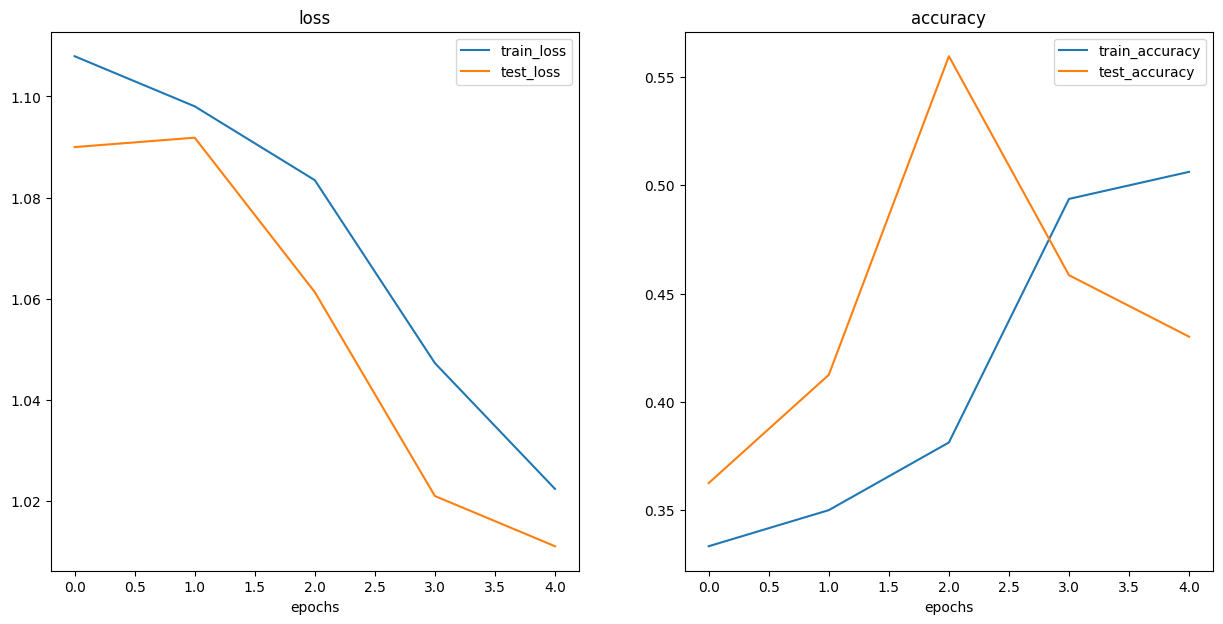

In [40]:
plot_loss_curves(model_008_results)

In [72]:
custom_image = data_path/"pizza.jpeg"


In [73]:
import torchvision
custom_image_tensor=torchvision.io.read_image(str(custom_image)).type(torch.float32)
custom_image_tensor=custom_image_tensor/255.0
print(f"custom image tensor: {custom_image_tensor}")
print(f"custom image shape: {custom_image_tensor.shape}")
print(f"custom image dtype: {custom_image_tensor.dtype}")

custom image tensor: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
custom image shape: torch.Size([3, 225, 225])
custom image dtype: torch.float32


(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

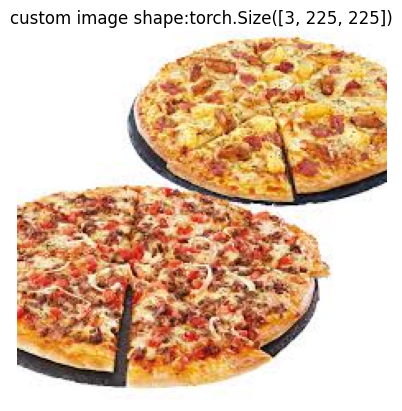

In [74]:
plt.imshow(custom_image_tensor.permute(1,2,0))
plt.title(f"custom image shape:{custom_image_tensor.shape}")
plt.axis(False)

In [75]:
image_transform=transforms.Compose([
    transforms.Resize((64,64))
    ])
custom_transformed_image=image_transform(custom_image_tensor)
print(f"custom transformed image shape: {custom_transformed_image.shape}")
print(f"Initial image shape: {custom_image_tensor.shape}")


custom transformed image shape: torch.Size([3, 64, 64])
Initial image shape: torch.Size([3, 225, 225])


In [76]:
model_008.eval()
with torch.inference_mode():
  img_pred=model_008(custom_transformed_image.unsqueeze(dim=0))
print(f"mage_pred shape: {img_pred.shape}")
print(f"transformed image shape: {custom_transformed_image.shape}")

mage_pred shape: torch.Size([1, 3])
transformed image shape: torch.Size([3, 64, 64])


In [77]:
custom_image_probs=torch.softmax(img_pred,dim=1)
custom_image_probs

tensor([[0.5660, 0.2010, 0.2330]])

In [78]:
#defining a function to predicct the image same as the several steps up there
def prediction(model:torch.nn.Module,
               image_path:str,
               class_names:List[str]=None,
               transform=None):
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image=target_image/255
  if transform:
    target_image=transform(target_image)

  model_008.eval()
  with torch.inference_mode():
    target_image_pred=model_008(target_image.unsqueeze(dim=0))
  target_image_prob=torch.softmax(target_image_pred, dim=1)
  target_image_pred_label=torch.argmax(target_image_prob, dim=1)



#plotting the image
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title=f"pred: {class_names[target_image_pred_label]} | prob: {target_image_prob.max():.3f}"
  else:
    title=f"pred: {target_image_pred_label} | Prob: {target_image_prob.max():.3f}"
  plt.axis(False)
  plt.title(title)

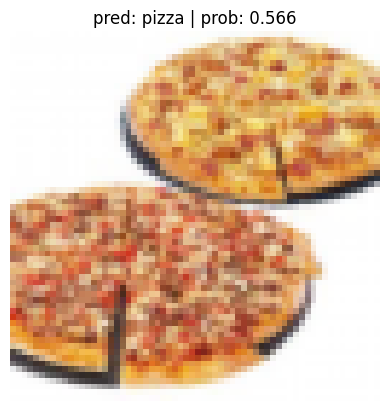

In [79]:
prediction(model=model_008,image_path=custom_image,class_names=class_names,transform=image_transform)